---
# **<p style="text-align: center; text-decoration: underline;">Introduction to Cycle-GANs</p>**
# **<p style="text-align: center;">Caycle Generative Adverserial Networks for Image-to-Image Translation</p>**
---

> Tutor: *Hazem Wannous*.

> Course: UV-NU-IMDA : Intelligent Multimedia Data Analytics, IMT Nord Europe

---

### ■ __Overview__
In this notebook, you will learn how to implement and train a CycleGAN model to translate images from one domain (satellite images) to another (map images). CycleGANs are an architecture that allows for image-to-image translation tasks without requiring paired datasets. Throughout this lab, we will go step-by-step through dataset preparation, model architecture, training, evaluation, and generating results.

The main task of this lab is to build a Cycle-GAN to transform Satellite images to maps and vice versa.
#### **Main Task: Satelitte-to-Map & vice versa**
![maps examples](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmachinelearningmastery.com%2Fwp-content%2Fuploads%2F2019%2F05%2FPlot-of-Three-Image-Pairs-Showing-Satellite-Images-top-and-Google-Map-Images-bottom-1024x768.png&f=1&nofb=1&ipt=2b33906fbc30178cd729b9c0f8275d6329122f4781769b81468a85f6e3851a34&ipo=images)

### ■ **<a name="content">Contents</a>**

- [1. Preliminaries](#section1)

- [2. Dataset](#section2)

- [3. Cycle-GAN Model](#section3)

- [4. Model Training](#section4)

- [5. Model Evaluation](#section5)

- [6. Bonus](#section6)


### ■ **Libraries**

In [4]:
!python --version

'1.13.0'

In [1]:
# !pip install torchvision==0.2.2
# !pip install Pillow==6.2.2

In [2]:
## torch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.utils import save_image

## basic dependencies from math and visualization
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time
from PIL import Image
from copy import deepcopy

/home/these/miniconda3/envs/MoGen/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/these/miniconda3/envs/MoGen/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
## Fix a seed to control randomness and make results reproducible!
def seed_everything(seed):
    """seeds every package that might introduce randomness."""
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(100)

#### **`Questions:`**
- What is the purpose of *seed_everything*? Why do we use it?

#### **> `Your Answer:`**

[Write your answer here !]

### ■ **<a name="pre">1. Preliminaries</a>** [(&#8593;)](#content)

#### **> `Questions:`**:
1. What is the key difference between CycleGANs and other GAN architectures?
2. Why is paired data not required for training a CycleGAN?
3. What are the two main objectives CycleGAN optimizes during training?
4. Describe other real-world applications of CycleGANs, other than satellite-to-map translation.

#### **> `Your Answers:`**

1. [Write your answer here !]
2. [Write your answer here !]
3. [Write your answer here !]
4. [Write your answer here !]

### ■ **<a name="dataset">2. Dataset</a>** [(&#8593;)](#content)
#### **2.1. About Maps dataset**

In this section, we will prepare our dataset. For this lab, we will use the `Maps` dataset from CycleGAN, which contains paired images of satellite and map views of the same locations. We’ll load the dataset, preprocess it, and create data loaders for training and testing.

#### **2.2. Download Maps dataset**
We start by downloading the `Maps` dataset. Run the code bellow to download the dataset, it will take some time.

In [4]:
## "Available datasets: ["apple2orange", "summer2winter_yosemite", "horse2zebra", "monet2photo", "cezanne2photo", "ukiyoe2photo", "vangogh2photo", "maps", "cityscapes", "facades", "iphone2dslr_flower", "ae_photos"]
dataset_name = "maps"
URL = "http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/{}.zip".format(dataset_name)
ZIP_FILE = "./{}_dataset.zip".format(dataset_name)
TARGET_DIR= "./{}_dataset/".format(dataset_name)

!wget -N $URL -O $ZIP_FILE
!mkdir $TARGET_DIR
!unzip $ZIP_FILE -d $TARGET_DIR
!rm $ZIP_FILE

The dataset is already divided into three parts: a training set, a validation set and a test set for both satellite images and maps.

#### **Define datasets & dataloaders**
Now, we define the maps dataset and dataloaders for training the Cycle-GAN.

In [5]:
class MapsDataset(Dataset):
    def __init__(self, root_satellite, root_maps, transform=None):
        self.root_satellite = root_satellite  ## Path to the folder containing satellite images
        self.root_maps = root_maps            ## Path to the folder containing map images
        self.transform = transform         

        ## Get lists of all files in the satellite and map directories
        self.satellite_images = sorted(os.listdir(root_satellite))
        self.maps_images = sorted(os.listdir(root_maps))
        
        ## The length of the dataset is the maximum of the two image sets to handle unequal datasets
        self.length_dataset = max(len(self.maps_images), len(self.satellite_images))
        
        self.satellite_len = len(self.satellite_images)
        self.maps_len = len(self.maps_images)

    ## Return the length of the dataset
    def __len__(self):
        return self.length_dataset

    ## Get a pair of images (satellite and map) for a given index
    def __getitem__(self, index):

        satellite_img = self.satellite_images[index % self.satellite_len]
        maps_img = self.maps_images[index % self.maps_len]

        ## Construct full paths to the satellite and map images
        satellite_path = os.path.join(self.root_satellite, satellite_img)
        maps_path = os.path.join(self.root_maps, maps_img)
        
        ## Open the images and convert them to RGB format, then convert to numpy arrays
        satellite_img = Image.open(satellite_path).convert("RGB")
        maps_img = Image.open(maps_path).convert("RGB")

        ## Apply transformations to the images, if provided
        if self.transform:
            satellite_img = self.transform(satellite_img)
            maps_img = self.transform(maps_img)

        return {'satellite_imgs': satellite_img, 'maps_imgs': maps_img}

In [6]:
## define data paths
train_dir_satellite = "./maps_dataset/maps/trainA/"
train_dir_maps = "./maps_dataset/maps/trainB/"

val_dir_satellite = "./maps_dataset/maps/valA/"
val_dir_maps = "./maps_dataset/maps/valB/"

test_dir_satellite = "./maps_dataset/maps/testA/"
test_dir_maps = "./maps_dataset/maps/testB/"

## define transformation
transforms = T.Compose([
                        T.Resize((256, 256)), # resize images to w=256 & h=256
                        T.ToTensor(), # transform numpy array to torch tensor
                        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # normalize images values to (-1, 1) interval
                    ])


## create training & validation & testing sets
train_dataset = MapsDataset(root_satellite=train_dir_satellite, 
                            root_maps=train_dir_maps,
                            transform=transforms)

valid_dataset = MapsDataset(root_satellite=val_dir_satellite,
                            root_maps=val_dir_maps,
                            transform=transforms)

test_dataset = MapsDataset(root_satellite=test_dir_satellite,
                           root_maps=test_dir_maps,
                           transform=transforms)

## create train & validation dataloaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



## print some stats
print('The number of training samples   :', len(train_dataset))
print('The number of validation samples :', len(valid_dataset))
print('The number of testing samples    :', len(test_dataset))

print('The number of training batches   :', len(train_loader))
print('The number of validation batches :', len(valid_loader))
print('The number of testing batches    :', len(test_loader))

The number of training samples   : 1096
The number of validation samples : 1098
The number of testing samples    : 1098
The number of training batches   : 274
The number of validation batches : 275
The number of testing batches    : 275


> **Note:** normalizing data to [−1,1] aligns well with GAN architectures, ensures stable and efficient training, and is a standard practice in GAN literature.

In [7]:
## check that the loaders work well by extracting an element from the laoder.
## out is a dictionary that contains a batch data from the loader.
out = next(iter(train_loader))

print('> Number of samples in batch:', len(out['satellite_imgs']))
print('> Shape of samples          :', out['satellite_imgs'][0].shape)
print('> min value:', out['satellite_imgs'].min(), '| max value:', out['satellite_imgs'].max())

> Number of samples in batch: 4
> Shape of samples          : torch.Size([3, 256, 256])
> min value: tensor(-1.) | max value: tensor(1.)


> **Note:** In PyTorch, the order of dimensions for an image tensor is (C, H, W) (channels, height, width), while in TensorFlow, it is (H, W, C) (height, width, channels).

#### **> `Questions:`**
1. What does *transforms* do ?
2. Why is it important to normalize image pixel values ?
3. Why is the *shuffle* parameter set to True for the training set and not for the validation and test sets?
4. Given the size of the dataset, do you think *batch_size* 4 is a good choice? why?
5. What is the purpose of each part of the data set (training set, validation set and test set)?

#### **> `Your Answers:`**

1. [Write your answer here !]
2. [Write your answer here !]
3. [Write your answer here !]
4. [Write your answer here !]
5. [Write your answer here !]

Let's plot some samples of the dataset.

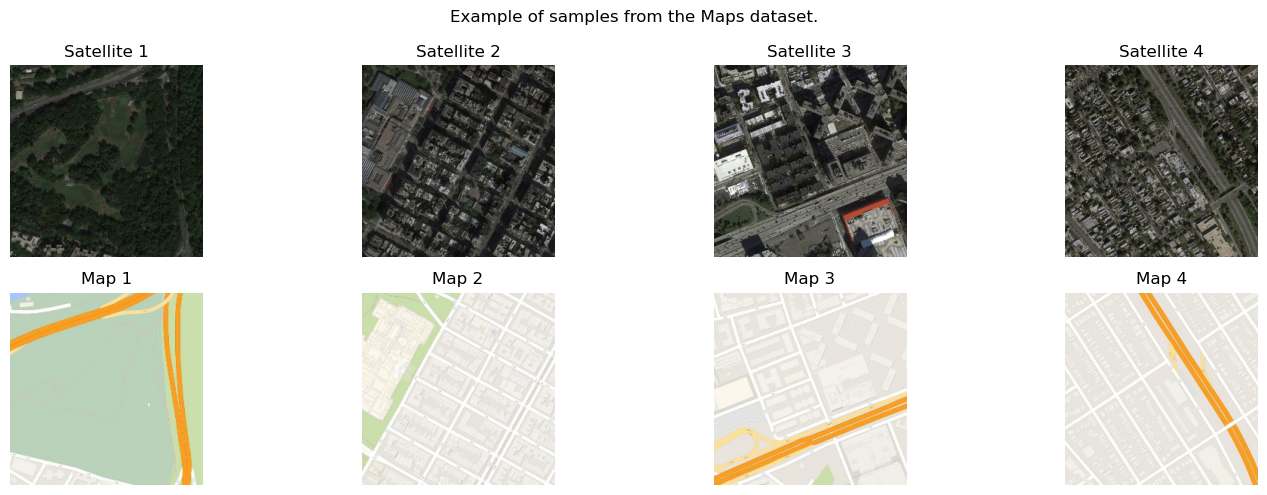

In [8]:
def display_satellite_map_pairs(satellite_images, map_images, suptitle=None):
    """
    Displays a set of satellite images with their corresponding map images in a dynamic grid.
    The first row shows satellite images, and the second row shows map images.

    Parameters:
    - satellite_images (torch.Tensor): Batch of satellite images of shape (B, C, W, H).
    - map_images (torch.Tensor): Batch of corresponding map images of shape (B, C, W, H).
    """
    ## Ensure the batch sizes of satellite and map images are the same
    assert satellite_images.shape[0] == map_images.shape[0], "Batch sizes must match!"

    ## denormalize image from (-1, 1) to (0, 255)
    satellite_images = ((satellite_images + 1.0) / 2) * 255
    map_images = ((map_images + 1.0) / 2) * 255

    ## Number of images in the batch
    batch_size = satellite_images.shape[0]

    ## Create subplots: two rows (satellite & maps), and a variable number of columns based on batch size
    fig, axes = plt.subplots(2, batch_size, figsize=(15, 5))

    for i in range(batch_size):
        # Convert tensors to numpy arrays for plotting
        sat_img = satellite_images[i].permute(1, 2, 0).cpu().numpy().astype("uint8")
        map_img = map_images[i].permute(1, 2, 0).cpu().numpy().astype("uint8")

        # Display satellite image in the first row
        axes[0, i].imshow(sat_img)
        axes[0, i].axis("off")
        axes[0, i].set_title(f"Satellite {i+1}")

        # Display map image in the second row
        axes[1, i].imshow(map_img)
        axes[1, i].axis("off")
        axes[1, i].set_title(f"Map {i+1}")

    if suptitle:
        plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()


display_satellite_map_pairs(out['satellite_imgs'], out['maps_imgs'], suptitle='Example of samples from the Maps dataset.')

### ■ **<a name="model">3. Cycle-GAN Model</a>** [(&#8593;)](#content)
Now, let’s define the CycleGAN model. CycleGANs consist of two generators and two discriminators. The generators learn to translate images from domain `X` to domain `Y` and vice versa, while the discriminators aim to distinguish between real and generated images in both domains. We'll define the architecture for both the generator and the discriminator, using a standard architecture for CycleGAN.

![Alt text](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fengineering.nordeus.com%2Fcontent%2Fimages%2F2020%2F10%2Fcyclegan-diagram.png&f=1&nofb=1&ipt=4f471303260eef1f7d508231ea10b05d0a7effa5fff92aff525315f5daa0f7f2&ipo=images)

#### **> `Question:`**
- Given the imabe above, describe each part of the image (a), (b) and (c).

#### **> `Your Answer:`**

- [Write your answer here !]

#### **3.1. Generator**

In [9]:
## Convolutional block that supports both downsampling (Conv2d) and upsampling (ConvTranspose2d)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        ## Use Conv2d for downsampling and ConvTranspose2d for upsampling
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)
    
## Residual block with two ConvBlocks to learn residual mappings
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        ## Add input to the output of the convolutional block (residual connection)
        return x + self.block(x)

## Generator network for image-to-image translation
class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 64, num_residuals=9):
        super().__init__()
        ## Initial convolution block with 7x7 kernel and reflection padding
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        
        ## Downsampling layers to reduce spatial dimensions
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        
        ## Residual blocks to capture deeper features while preserving input details
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        
        ## Upsampling layers to restore original spatial dimensions
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        ## Final convolution to produce the output image with the same number of channels as the input
        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

#### **> `Question:`**
- Describe the generator components (layers and purpose of each layer).

#### **> `Your Answer:`**

- [Write your answer here !]

#### **3.2. Discriminator**

In [10]:
## A convolutional block used in the Discriminator
class CNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride = 2):
        super(CNNBlock,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,4,stride,1,bias=True,padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels), ## Normalize features for better training stability
            nn.LeakyReLU(0.2,inplace=True) ## Leaky ReLU activation to allow small gradients for negative inputs
        )
    def forward(self,x):
        return self.conv(x)

## PatchGAN Discriminator for distinguishing real and fake image patches
class Discriminator(nn.Module):
    def __init__(self,in_channels = 3,features = [64,128,256,512]):
        super(Discriminator,self).__init__()
        ## Initial convolution (as per PatchGAN architecture)
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels,out_channels=features[0],kernel_size=4,stride=2,padding=1,padding_mode='reflect'),
            nn.LeakyReLU(0.2,inplace=True)
        )
        
        ## Build additional convolutional layers using CNNBlock
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(CNNBlock(in_channels,out_channels=feature,stride=1 if feature==features[-1] else 2))
            in_channels = feature
            
        ## Final layer to map features to a single channel output (real/fake score)
        layers.append(nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1,padding_mode='reflect'))
        self.model = nn.Sequential(*layers)

    def forward(self,x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

#### **> `Question:`**
- Describe the descriminator components (layers and purpose of each layer).

#### **> `Your Answer:`**

- [Write your answer here !]

#### **> `Questions:`**
1. Explain the purpose of instance normalization in the generator and discriminator architectures.
2. Why does the generator output use a tanh activation function, while the discriminator uses a LeakyReLU?

#### **> `Your Answers:`**

1. [Write your answer here !]
2. [Write your answer here !]

### ■ **<a name="train">4. Model Training</a>** [(&#8593;)](#content)

#### **4.1. Training & validation functions**
We are now ready to train our model. We define a `train_epoch` function to train the models for one epoch. We also define a `valid_epoch` function to validate the models for one epoch.

In [11]:
def train_epoch(epoch, device, disc_DX, disc_DY, gen_G, gen_F, opt_disc, opt_gen, g_scaler, d_scaler, mse, L1, loader, lambda_cycle):
    """to train the models for one epoch"""
    
    ## put models in training mode
    disc_DX.train()
    disc_DY.train()
    gen_G.train()
    gen_F.train()

    ## Create a progress bar for the training loop
    loop = tqdm(loader,leave=True, desc='training [epoch {}]'.format(epoch))
    epoch_disc_loss, epoch_gen_loss = 0.0, 0.0
    
    for idx, batch in enumerate(loop):
        
        satellite_imgs = batch['satellite_imgs'].to(device)
        maps_imgs = batch['maps_imgs'].to(device)

        ## ===========================
        ## Train Discriminators (DX & DY)
        ## ===========================
        with torch.amp.autocast(device):
            ## Generate fake map images (X -> Y)
            fake_maps = gen_G(satellite_imgs)
            
            ## Discriminator DY: Evaluate real and fake map images
            D_G_real = disc_DY(maps_imgs)
            D_G_fake = disc_DY(fake_maps.detach())
            D_G_real_loss = mse(D_G_real, torch.ones_like(D_G_real))
            D_G_fake_loss = mse(D_G_fake, torch.zeros_like(D_G_fake))
            D_G_loss = D_G_real_loss + D_G_fake_loss

            ## Generate fake satellite images (Y -> X)
            fake_satellite = gen_F(maps_imgs)
            
            ## Discriminator DX: Evaluate real and fake satellite images
            D_F_real = disc_DX(satellite_imgs)
            D_F_fake = disc_DX(fake_satellite.detach())
            D_F_real_loss = mse(D_F_real, torch.ones_like(D_F_real))
            D_F_fake_loss = mse(D_F_fake, torch.zeros_like(D_F_fake))
            D_F_loss = D_F_real_loss + D_F_fake_loss

            ## Combined discriminator loss
            D_loss = (D_G_loss + D_F_loss) / 2

        ## Backpropagation and optimization for the discriminators
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        ## =====================
        ## Train Generators (G & F)
        ## =====================
        with torch.amp.autocast(device):
            ## Adversarial loss for generators
            D_Y_fake = disc_DY(fake_maps)
            D_X_fake = disc_DX(fake_satellite)
            loss_G_Y = mse(D_Y_fake,torch.ones_like(D_Y_fake))
            loss_G_X = mse(D_X_fake, torch.ones_like(D_X_fake))
            
            ## Cycle consistency loss
            cycle_maps = gen_F(fake_maps)
            cycle_satellite = gen_G(fake_satellite)
            cycle_satellite_loss = L1(satellite_imgs, cycle_maps)
            cycle_maps_loss = L1(maps_imgs, cycle_satellite)

            ## Total generator loss
            G_loss = (
                loss_G_X
                + loss_G_Y
                + cycle_satellite_loss * lambda_cycle
                + cycle_maps_loss * lambda_cycle
            )

        ## Backpropagation and optimization for the generators
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        
        epoch_disc_loss += D_loss.item()
        epoch_gen_loss += G_loss.item()
        
    # Average the losses for the epoch
    epoch_disc_loss /= len(loader)
    epoch_gen_loss /= len(loader)
    
    return epoch_disc_loss, epoch_gen_loss


def valid_epoch(epoch, device, disc_DX, disc_DY, gen_G, gen_F, mse, L1, loader, lambda_cycle):
    """to validate the models for one epoch"""
    
    ## put models in training mode
    disc_DX.eval()
    disc_DY.eval()
    gen_G.eval()
    gen_F.eval()
    
    ## Create a progress bar for the training loop
    loop = tqdm(loader,leave=True, desc='validation [epoch {}]'.format(epoch))
    epoch_disc_loss, epoch_gen_loss = 0.0, 0.0
    
    ## no need to compute gradients (optimize time)
    with torch.no_grad():

        for idx, batch in enumerate(loop):

            satellite_imgs = batch['satellite_imgs'].to(device)
            maps_imgs = batch['maps_imgs'].to(device)

            ## ===========================
            ## evaluate Discriminators (DX & DY)
            ## ===========================
            ## Generate fake map images (X -> Y)
            fake_maps = gen_G(satellite_imgs)

            ## Discriminator DY: Evaluate real and fake map images
            D_G_real = disc_DY(maps_imgs)
            D_G_fake = disc_DY(fake_maps.detach())
            D_G_real_loss = mse(D_G_real, torch.ones_like(D_G_real))
            D_G_fake_loss = mse(D_G_fake, torch.zeros_like(D_G_fake))
            D_G_loss = D_G_real_loss + D_G_fake_loss

            ## Generate fake satellite images (Y -> X)
            fake_satellite = gen_F(maps_imgs)

            ## Discriminator DX: Evaluate real and fake satellite images
            D_F_real = disc_DX(satellite_imgs)
            D_F_fake = disc_DX(fake_satellite.detach())
            D_F_real_loss = mse(D_F_real, torch.ones_like(D_F_real))
            D_F_fake_loss = mse(D_F_fake, torch.zeros_like(D_F_fake))
            D_F_loss = D_F_real_loss + D_F_fake_loss

            ## Combined discriminator loss
            D_loss = (D_G_loss + D_F_loss) / 2

            ## =====================
            ## evaluate Generators (G & F)
            ## =====================
            ## Adversarial loss for generators
            D_Y_fake = disc_DY(fake_maps)
            D_X_fake = disc_DX(fake_satellite)
            loss_G_Y = mse(D_Y_fake,torch.ones_like(D_Y_fake))
            loss_G_X = mse(D_X_fake, torch.ones_like(D_X_fake))

            ## Cycle consistency loss
            cycle_maps = gen_F(fake_maps)
            cycle_satellite = gen_G(fake_satellite)
            cycle_satellite_loss = L1(satellite_imgs, cycle_maps)
            cycle_maps_loss = L1(maps_imgs, cycle_satellite)

            ## Total generator loss
            G_loss = (
                loss_G_X
                + loss_G_Y
                + cycle_satellite_loss * lambda_cycle
                + cycle_maps_loss * lambda_cycle
            )

            epoch_disc_loss += D_loss.item()
            epoch_gen_loss += G_loss.item()

    # Average the losses for the epoch
    epoch_disc_loss /= len(loader)
    epoch_gen_loss /= len(loader)

    ## Save images for visualization
    os.makedirs("./saved_images", exist_ok=True)
    save_image(maps_imgs*0.5+0.5, f"./saved_images/maps_{epoch}.png")
    save_image(fake_maps*0.5+0.5, f"./saved_images/fake_maps_{epoch}.png")
    save_image(satellite_imgs*0.5+0.5, f"./saved_images/satellite_{epoch}.png")
    save_image(fake_satellite*0.5+0.5, f"./saved_images/fake_satellite_{epoch}.png")
    
    return epoch_disc_loss, epoch_gen_loss

#### **> `Questions:`**
1. Describe the role of the cycle consistency loss in this framework.
2. Complete the code for computing the cycle consistency loss for the generators, and the discriminator loss.
3. What does `torch.no_grad()` do ?

#### **> `Your Answers:`**

1. [Write your answer here !]
2. [Write your answer here !]
3. [Write your answer here !]

#### **4.2. Define models & training hyperparameters**

In [12]:
## Set device to GPU if available, otherwise use CPU
device = "cuda" if torch.cuda.is_available else "cpu"

## Hyperparameters
lr = 1e-5  ## Learning rate
lambda_cycle = 10  ## Weight for cycle consistency loss
num_epochs = 20   ## Number of training epochs

## Initialize discriminators for both domains (DX for domain X, DY for domain Y)
disc_DX = Discriminator(in_channels=3).to(device)
disc_DY = Discriminator(in_channels=3).to(device)

## Initialize generators (G maps domain X -> Y, F maps domain Y -> X)
gen_G = Generator(img_channels=3,num_residuals=9).to(device)
gen_F = Generator(img_channels=3,num_residuals=9).to(device)

## Optimizers for discriminators and generators
opt_disc = optim.Adam(
    list(disc_DX.parameters()) + list(disc_DY.parameters()),
    lr=lr,
    betas= (0.5,0.999)
)
opt_gen = optim.Adam(
    list(gen_G.parameters()) + list(gen_F.parameters()),
    lr=lr,
    betas= (0.5,0.999)
)

## Loss functions
mse = nn.MSELoss()
L1 = nn.L1Loss()

## Gradient scalers for mixed precision training on GPU (improves training efficiency)
g_scaler = torch.amp.GradScaler(device)
d_scaler = torch.amp.GradScaler(device)

#### **> `Questions:`**
1. Why are two discriminators (DX and DY) needed in this model?
2. What is the purpose of using two Adam optimizers in this training loop?
3. Explain the effect of the lambda_cycle hyperparameter. What happens if it is set too low or too high?
6. Complete the code above with the appropriate parameters to train the model.

#### **> `Your Answers:`**

1. [Write your answer here !]
2. [Write your answer here !]
3. [Write your answer here !]
4. [Write your answer here !]

#### **4.3. Training Loop**

In [13]:
train_disc_losses, train_gen_losses = [], []
valid_disc_losses, valid_gen_losses = [], []


best_val = float('inf') ## initial best loss value is set to +infinity
best_epoch = 0

## chrono
start_time = time.time()

for epoch in range(num_epochs):
    
    ## train for one epoch
    train_disc_loss, train_gen_loss = train_epoch(epoch+1, device, disc_DX, disc_DY, gen_G, gen_F, 
                                                 opt_disc, opt_gen, g_scaler, d_scaler, mse, L1,
                                                 train_loader, lambda_cycle)
    
    ## validate the epoch
    valid_disc_loss, valid_gen_loss = valid_epoch(epoch+1, device, disc_DX, disc_DY, gen_G, gen_F, 
                                                  mse, L1, valid_loader, lambda_cycle)
    
    ## store train & validation epoch losses
    train_disc_losses.append(train_disc_loss)
    train_gen_losses.append(train_gen_loss)
    
    valid_disc_losses.append(valid_disc_loss)
    valid_gen_losses.append(valid_gen_loss)
    
    ## save best models
    if valid_gen_loss < best_val:
        best_epoch = epoch
        best_val = valid_gen_loss
        
        best_gen_G = deepcopy(gen_G)
        best_gen_F = deepcopy(gen_F)
        best_disc_DX = deepcopy(disc_DX)
        best_disc_DY = deepcopy(disc_DY)
    
## stop chrono
train_time = time.time() - start_time
mins, secs = divmod(train_time, 60)
print('\n> Training took {} [min:sec]'.format(f"{int(mins):02}:{int(secs):02}"))

validation [epoch 20]: 100%|██████████████████| 275/275 [01:26<00:00,  3.16it/s]



> Training took 00:12 [min:sec]


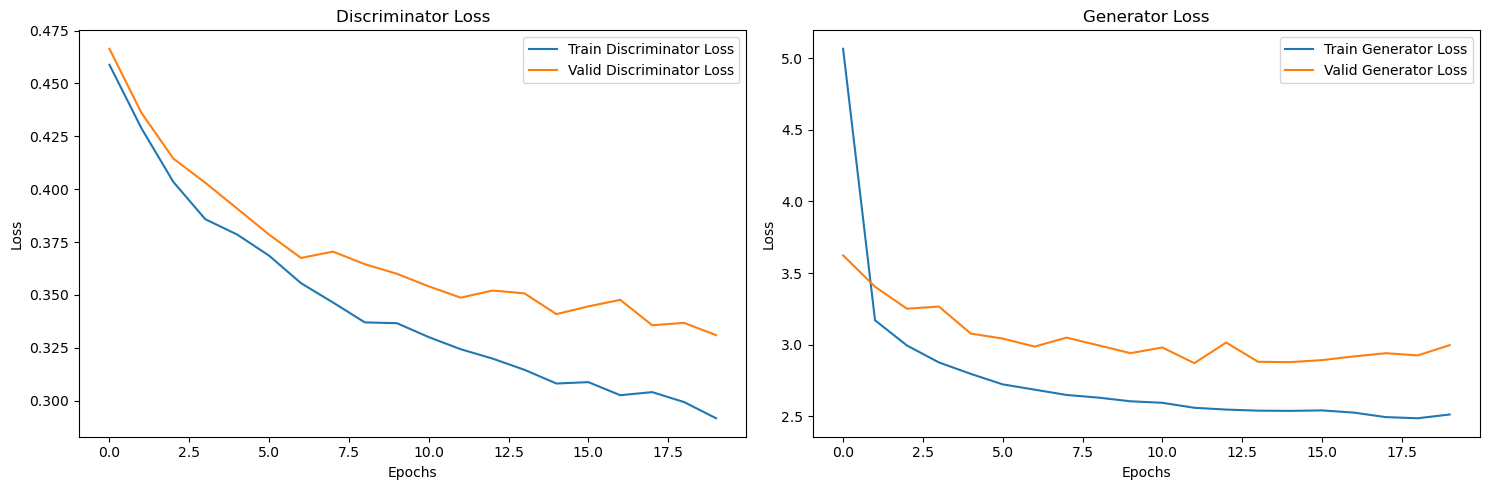

In [14]:
## Plotting the losses
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_disc_losses, label='Train Discriminator Loss')
plt.plot(valid_disc_losses, label='Valid Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_gen_losses, label='Train Generator Loss')
plt.plot(valid_gen_losses, label='Valid Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### **> `Question:`**
- Describe loss curves.

#### **> `Your Answer:`**

- [Write your answer here !]

### ■ **<a name="eval">5. Model Evaluation</a>** [(&#8593;)](#content)

In this section, we evaluate the performance of the CycleGAN model using several key metrics to assess the quality of the generated images. These metrics provide insight into how well the model has learned to map between the satellite and map domains.

#### **5.1. Visualize some results**

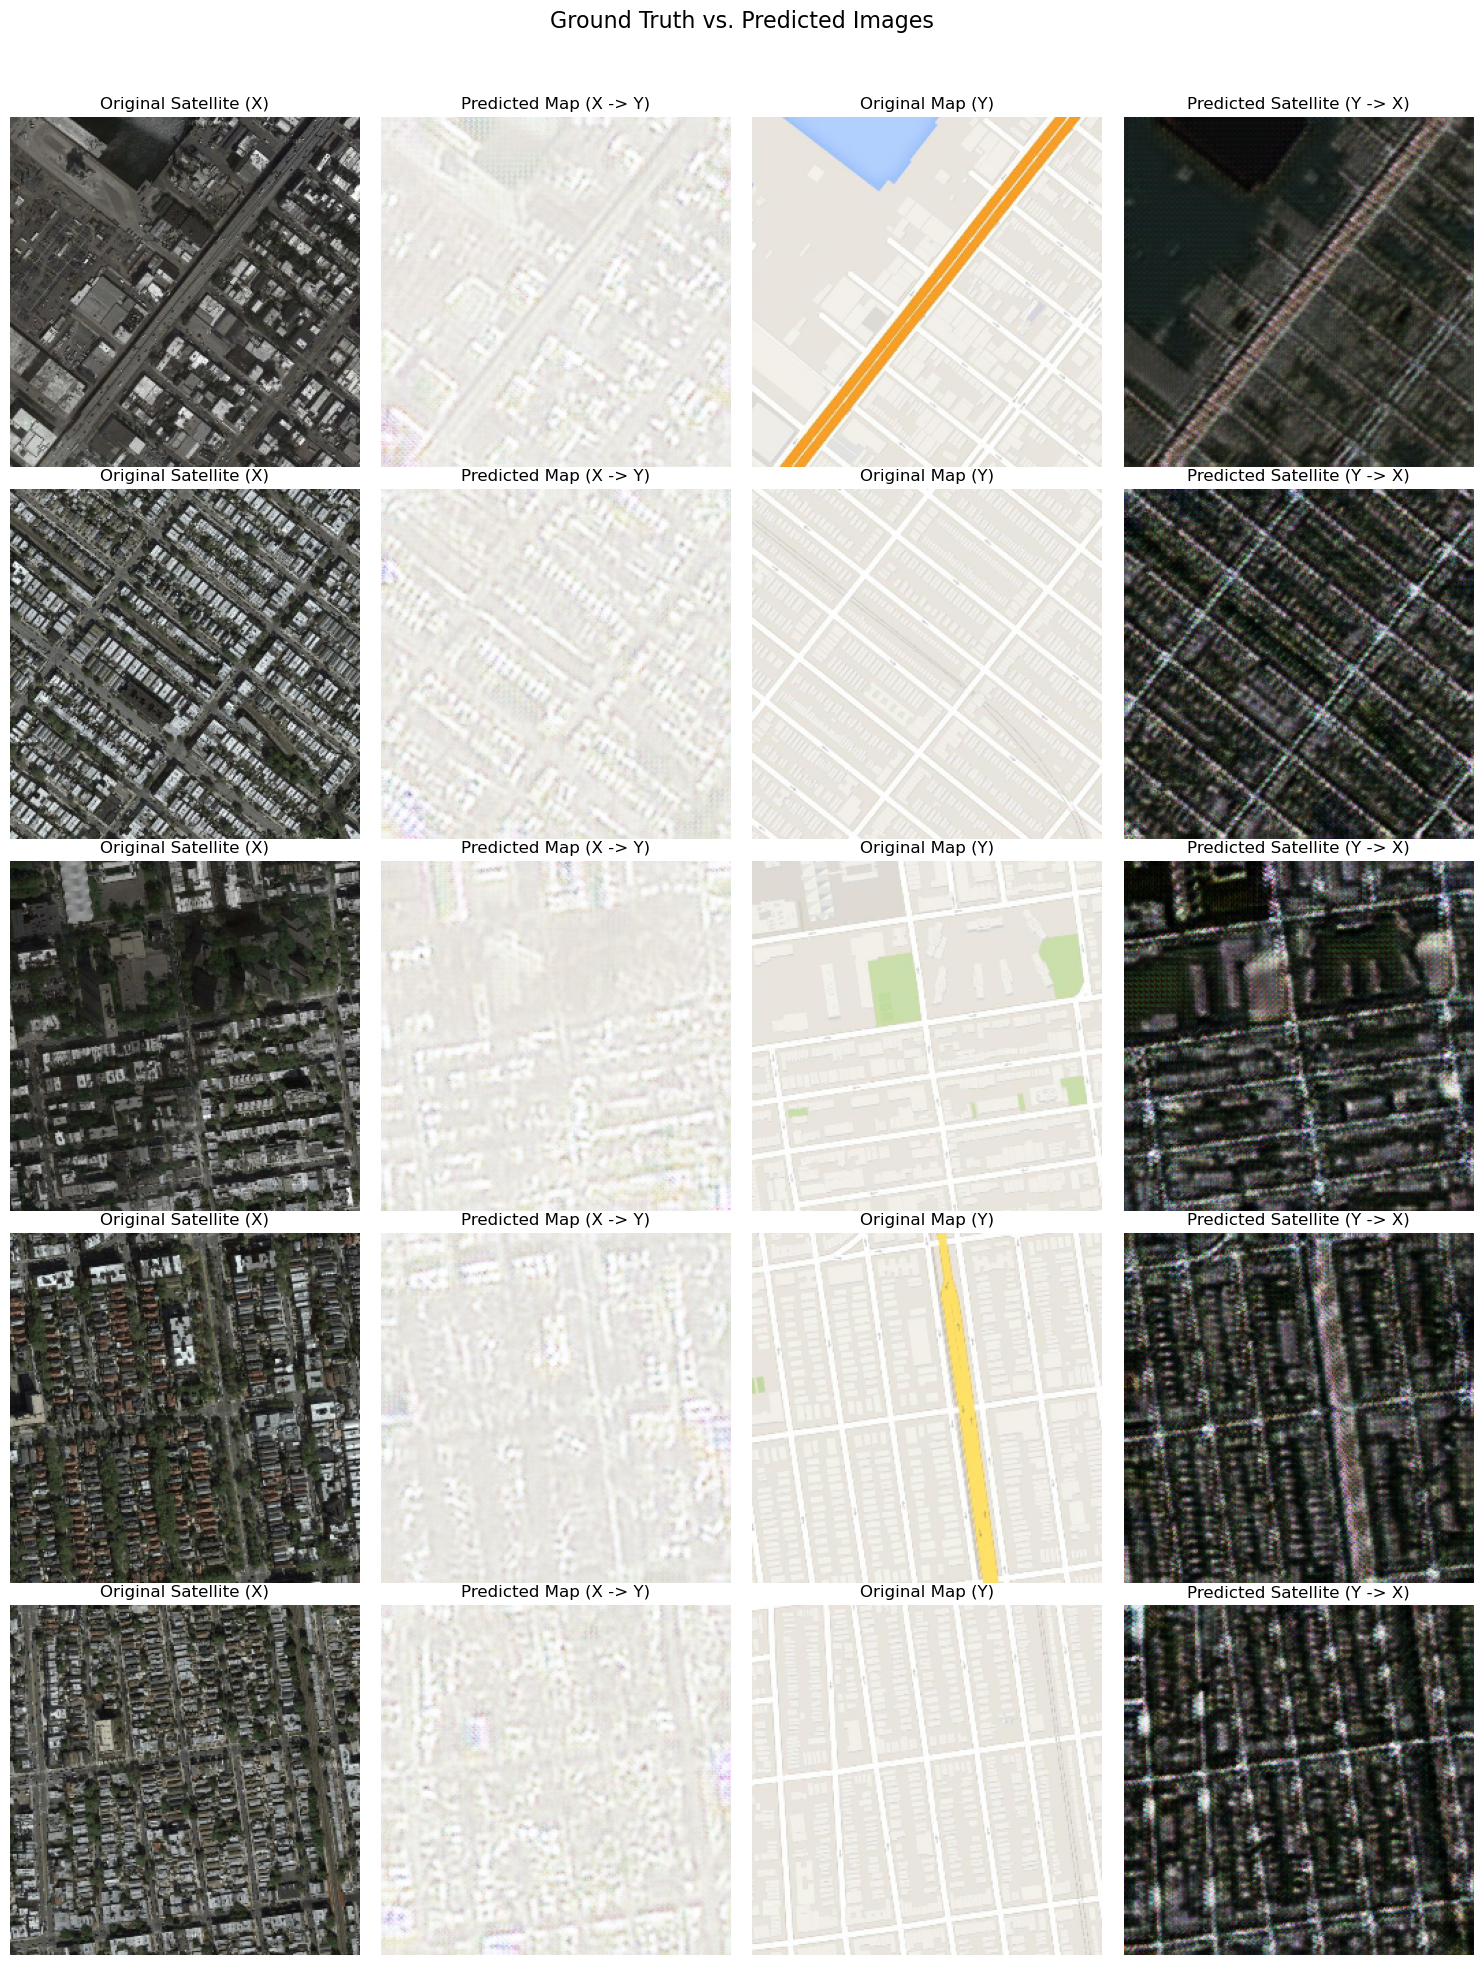

In [15]:
def plot_predictions(gen_G, gen_F, dataloader, device, num_samples=5):
    """
    Plot original images and their corresponding predicted images using the trained generators.
    
    Args:
        gen_G (nn.Module): Generator G (domain X -> Y).
        gen_F (nn.Module): Generator F (domain Y -> X).
        dataloader (torch.utils.data.DataLoader): Dataloader containing the test data.
        device (str): Device to run the models on ("cpu" or "cuda").
        num_samples (int): Number of samples to plot.
    """
    gen_G.eval()  # Set generator G to evaluation mode
    gen_F.eval()  # Set generator F to evaluation mode
    
    data_iter = iter(dataloader)
    fig, axes = plt.subplots(num_samples, 4, figsize=(15, num_samples * 4))
    fig.suptitle("Ground Truth vs. Predicted Images", fontsize=16)
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for i in range(num_samples):
            # Fetch a batch of data
            batch = next(data_iter)
            satellite_imgs = batch['satellite_imgs'].to(device)  # Domain X
            maps_imgs = batch['maps_imgs'].to(device)            # Domain Y
            
            # Generate predictions
            fake_maps = gen_G(satellite_imgs)  # X -> Y
            fake_satellite = gen_F(maps_imgs)  # Y -> X
            
            # Normalize images from [-1, 1] to [0, 1] for visualization
            satellite_imgs = (satellite_imgs + 1) / 2
            maps_imgs = (maps_imgs + 1) / 2
            fake_maps = (fake_maps + 1) / 2
            fake_satellite = (fake_satellite + 1) / 2
            
            # Plot the results
            axes[i, 0].imshow(satellite_imgs[0].permute(1, 2, 0).cpu().numpy())
            axes[i, 0].set_title("Original Satellite (X)")
            axes[i, 0].axis("off")
            
            axes[i, 1].imshow(fake_maps[0].permute(1, 2, 0).cpu().numpy())
            axes[i, 1].set_title("Predicted Map (X -> Y)")
            axes[i, 1].axis("off")
            
            axes[i, 2].imshow(maps_imgs[0].permute(1, 2, 0).cpu().numpy())
            axes[i, 2].set_title("Original Map (Y)")
            axes[i, 2].axis("off")
            
            axes[i, 3].imshow(fake_satellite[0].permute(1, 2, 0).cpu().numpy())
            axes[i, 3].set_title("Predicted Satellite (Y -> X)")
            axes[i, 3].axis("off")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    ## models back to train mode
    gen_G.train()
    gen_F.train()
    
    
plot_predictions(best_gen_G, best_gen_F, test_loader, device)

#### **5.2. Evaluation Metrics**
The evaluation includes the following metrics:

1. **Root Mean Square Error (RMSE)**:  
   
   $RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}$
   
   RMSE measures the pixel-wise difference between the ground truth and the generated image. Lower RMSE values indicate better accuracy in reproducing the target image.

2. **Structural Similarity Index Measure (SSIM)**:  
   
   $SSIM(x, y) = \frac{(2 \mu_x \mu_y + c_1)(2 \sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$
   
   SSIM evaluates the perceptual similarity between two images, taking into account luminance, contrast, and structure. A higher SSIM value indicates more similarity between the ground truth and the generated image.

3. **Peak Signal-to-Noise Ratio (PSNR)**:  
   
   $PSNR = 10 \cdot \log_{10}\left(\frac{MAX_I^2}{MSE}\right)$
   
   PSNR quantifies the quality of an image by comparing the maximum possible pixel value to the mean squared error between the original and generated images. Higher PSNR values indicate better image quality and less distortion.

These metrics collectively offer a comprehensive evaluation of the model's ability to generate realistic and high-quality images across the satellite and map domains.

#### **> `Questions`**
1. Explain why RMSE, SSIM, and PSNR are suitable metrics for this task.
2. What is the significance of structural similarity (SSIM) in evaluating image quality?
3. How would you interpret a high PSNR but low SSIM value?
4. Implement a function to calculate the average evaluation metrics over the entire validation set.

#### **> `Your Answers:`**

1. [Write your answer here !]
2. [Write your answer here !]
3. [Write your answer here !]
4. [Write your answer here !]

#### **5.3. Evaluation Loop**

In [16]:
from skimage.metrics import structural_similarity as ssim

def evaluate_models(gen_G, gen_F, val_loader, mse, device):
    ## Initialize accumulators for metrics
    total_rmse = 0.0
    total_ssim = 0.0
    total_psnr = 0.0
    total_loss = 0.0
    num_batches = 0

    ## Switch models to evaluation mode
    gen_G.eval()
    gen_F.eval()

    with torch.no_grad():  # Disable gradient calculation for validation
        for batch in tqdm(val_loader, leave=True, desc="Evaluation...."):
            ## Get satellite and map images
            satellite_imgs = batch['satellite_imgs'].to(device)
            maps_imgs = batch['maps_imgs'].to(device)

            ## Generate fake images
            fake_maps = gen_G(satellite_imgs)
            fake_satellite = gen_F(maps_imgs)

            ## Compute losses
            cycle_maps = gen_F(fake_maps)
            cycle_satellite = gen_G(fake_satellite)
            cycle_satellite_loss = L1(satellite_imgs, cycle_maps)
            cycle_maps_loss = L1(maps_imgs, cycle_satellite)
            loss = cycle_satellite_loss + cycle_maps_loss
            total_loss += loss.item()

            ## Compute metrics per batch
            for real, fake in [(maps_imgs, fake_maps), (satellite_imgs, fake_satellite)]:
                ## Denormalize images from [-1, 1] to [0, 1]
                real_np = ((real * 0.5 + 0.5) * 255).cpu().numpy().astype(np.uint8)
                fake_np = ((fake * 0.5 + 0.5) * 255).cpu().numpy().astype(np.uint8)

                ## Reshape tensors to (B, H, W, C) for SSIM and PSNR calculations
                real_np = real_np.transpose(0, 2, 3, 1)
                fake_np = fake_np.transpose(0, 2, 3, 1)

                for r, f in zip(real_np, fake_np):
                    ## RMSE
                    rmse = np.sqrt(np.mean((r - f) ** 2))
                    total_rmse += rmse

                    ## SSIM
                    ssim_val = ssim(r, f, multichannel=True, win_size=3)
                    total_ssim += ssim_val

                    ## PSNR
                    mse_val = np.mean((r - f) ** 2)
                    psnr = 20 * np.log10(255.0 / np.sqrt(mse_val))
                    total_psnr += psnr

            num_batches += real.size(0)

    ## Compute average metrics
    avg_loss = total_loss / len(val_loader)
    avg_rmse = total_rmse / (num_batches * 2)  # Two image types (maps and satellite)
    avg_ssim = total_ssim / (num_batches * 2)
    avg_psnr = total_psnr / (num_batches * 2)

    ## Print metrics
    print(f"Evaluation Loss: {avg_loss:.4f}")
    print(f"Evaluation RMSE: {avg_rmse:.4f}")
    print(f"Evaluation SSIM: {avg_ssim:.4f}")
    print(f"Evaluation PSNR: {avg_psnr:.4f}")

    return avg_loss, avg_rmse, avg_ssim, avg_psnr


evaluate_models(best_gen_G, best_gen_F, test_loader, mse, device)

Evaluation....: 100%|█████████████████████████| 275/275 [01:53<00:00,  2.42it/s]

Evaluation Loss: 0.2049
Evaluation RMSE: 9.4932
Evaluation SSIM: 0.3045
Evaluation PSNR: 28.6116


(0.20486486732959747,
 9.493224290492796,
 0.3045394681796616,
 28.611593562516525)

#### **> `Question:`**
- Comment these results ?

#### **> `Your Answer:`**

- [Write your answer here !]

### ■ **<a name="bonus">6. Bonus</a>** [(&#8593;)](#content)


**Implement Identity Loss**
- How would you compute and incorporate identity loss into the training process?
- What is the role of identity loss in the CycleGAN model?

----